## Parameters

In [1]:
wdir = 'cpTree_v6/'
sample_file = 'cpTree_v6_tree.csv'

## Functions

In [4]:
import pandas as pd
import os
import numpy as np
from Bio import SeqIO
from ete3 import Tree
import seaborn as sns
from matplotlib import pyplot as plt
from random import sample

C:\ProgramData\Anaconda3\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\ProgramData\Anaconda3\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [5]:
def taxo_stats(df2):
    df = df2.copy()
    df.columns = df.columns.str.lower()
    if 'sci_name' in df.columns:
        print(df.shape[0],'o:',df.order.nunique(),'f:',df.family.nunique(),'g:',df.genus.nunique(),'s:',df.sci_name.nunique())
    else:
        print(df.shape[0],'o:',df.order.nunique(),'f:',df.family.nunique(),'g:',df.genus.nunique())
root_orders = ['Pinales','Gnetales','Cupressales','Ginkgoales','Ephedrales','Cupressales','Araucariales','Cycadales','Taxales','Welwitschiales']

## Load df and tree

In [6]:
# Set working directory
os.chdir(wdir)

# Alignments

In [9]:
SamplesV = pd.read_csv(sample_file.replace('.csv','_clean.csv'))
taxo_stats(SamplesV)
SamplesV.head(2)

16682 o: 69 f: 420 g: 6126 s: 14933


,Sample_Name,genus,species,sci_name,DataSource,length,order,class,family,nentries,TaxID,mol_type,Label
0,GAP_026547,Albidella,oligococca,Albidella oligococca,GAP,59917.0,Alismatales,monocots,Alismataceae,4.0,NaN,NaN,Alismatales_Alismataceae_Albidella_oligococca_...
1,GAP_026933,Stuckenia,pectinata,Stuckenia pectinata,GAP,31766.0,Alismatales,monocots,Potamogetonaceae,10.0,NaN,NaN,Alismatales_Potamogetonaceae_Stuckenia_pectina...


## Gene alignment stats

In [10]:
def desc_to_dc(description, gene, seqid):
    descc = description.replace(seqid,'').replace('-'+gene,'').replace('  ','')\
    .replace('{','').replace('}','').replace(', ',',')
    ls_desc = descc.split(',')
    desc_dc = {}
    for ifeat in ls_desc:
        desc_dc[ifeat.split(':')[0]] = ifeat.split(':')[1]
    return desc_dc

In [12]:
gene_list = pd.read_csv('../cp_genes_82.txt',header=None).rename(columns={0:'gene'})
for gene in gene_list.gene:
    try:
        gene_file = gene + '_aln.fasta'
        ls_seq = {}
        for record in SeqIO.parse('Aligned_genes/' + gene_file, format='fasta'):
        #     ls_seq.append('Sample_Name':record.id)
        #     print(record.description)
            try:
                ls_seq[record.id] = desc_to_dc(description = record.description, gene = gene, seqid = record.id)
            except:
                pass
        seq_df = pd.DataFrame.from_dict(ls_seq,orient='index')
        seq_df.reset_index().to_csv('Aligned_genes/' + gene + '_stats.csv',index=False)
    except:
        print('no file for', gene)

In [14]:
tmp = os.listdir('Aligned_genes/')
stat_files = [ifile for ifile in tmp if '_stats.csv' in ifile]
all_stats = pd.DataFrame()
for ifile in stat_files:
    tmp = pd.read_csv('Aligned_genes/' + ifile).rename(columns={'index':'Sample_Name'})
    tmp['gene'] = ifile.replace('_stats.csv','')
    all_stats = pd.concat([all_stats,tmp],ignore_index=True)

<ipython-input-14-3840bb40d867>:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_stats = pd.concat([all_stats,tmp],ignore_index=True)


In [15]:
all_stats_paftol = all_stats[all_stats.Sample_Name.isin(
    Samples[Samples.DataSource.isin(['PAFTOL','GAP'])].Sample_Name)]
print(all_stats_paftol.groupby('overlap').size().to_dict())
print(all_stats_paftol.reference_coverage.quantile([.1,.5,.9]).to_dict())
all_stats_paftol.head(2)

{False: 177857, True: 16184}
{0.1: 71.1, 0.5: 100.0, 0.9: 100.0}


,Sample_Name,bitscore,gene,length,organism-gene,originalID,overlap,pident,reference_coverage
3,PAFTOL_005280,2362.0,accD,1461.0,NC_037845.1,100087+_100049+_9675,False,95.96,100.0
24,PAFTOL_004234,1354.0,accD,1002.0,NC_049157.1,scaffold_32--153295+,False,91.12,67.1


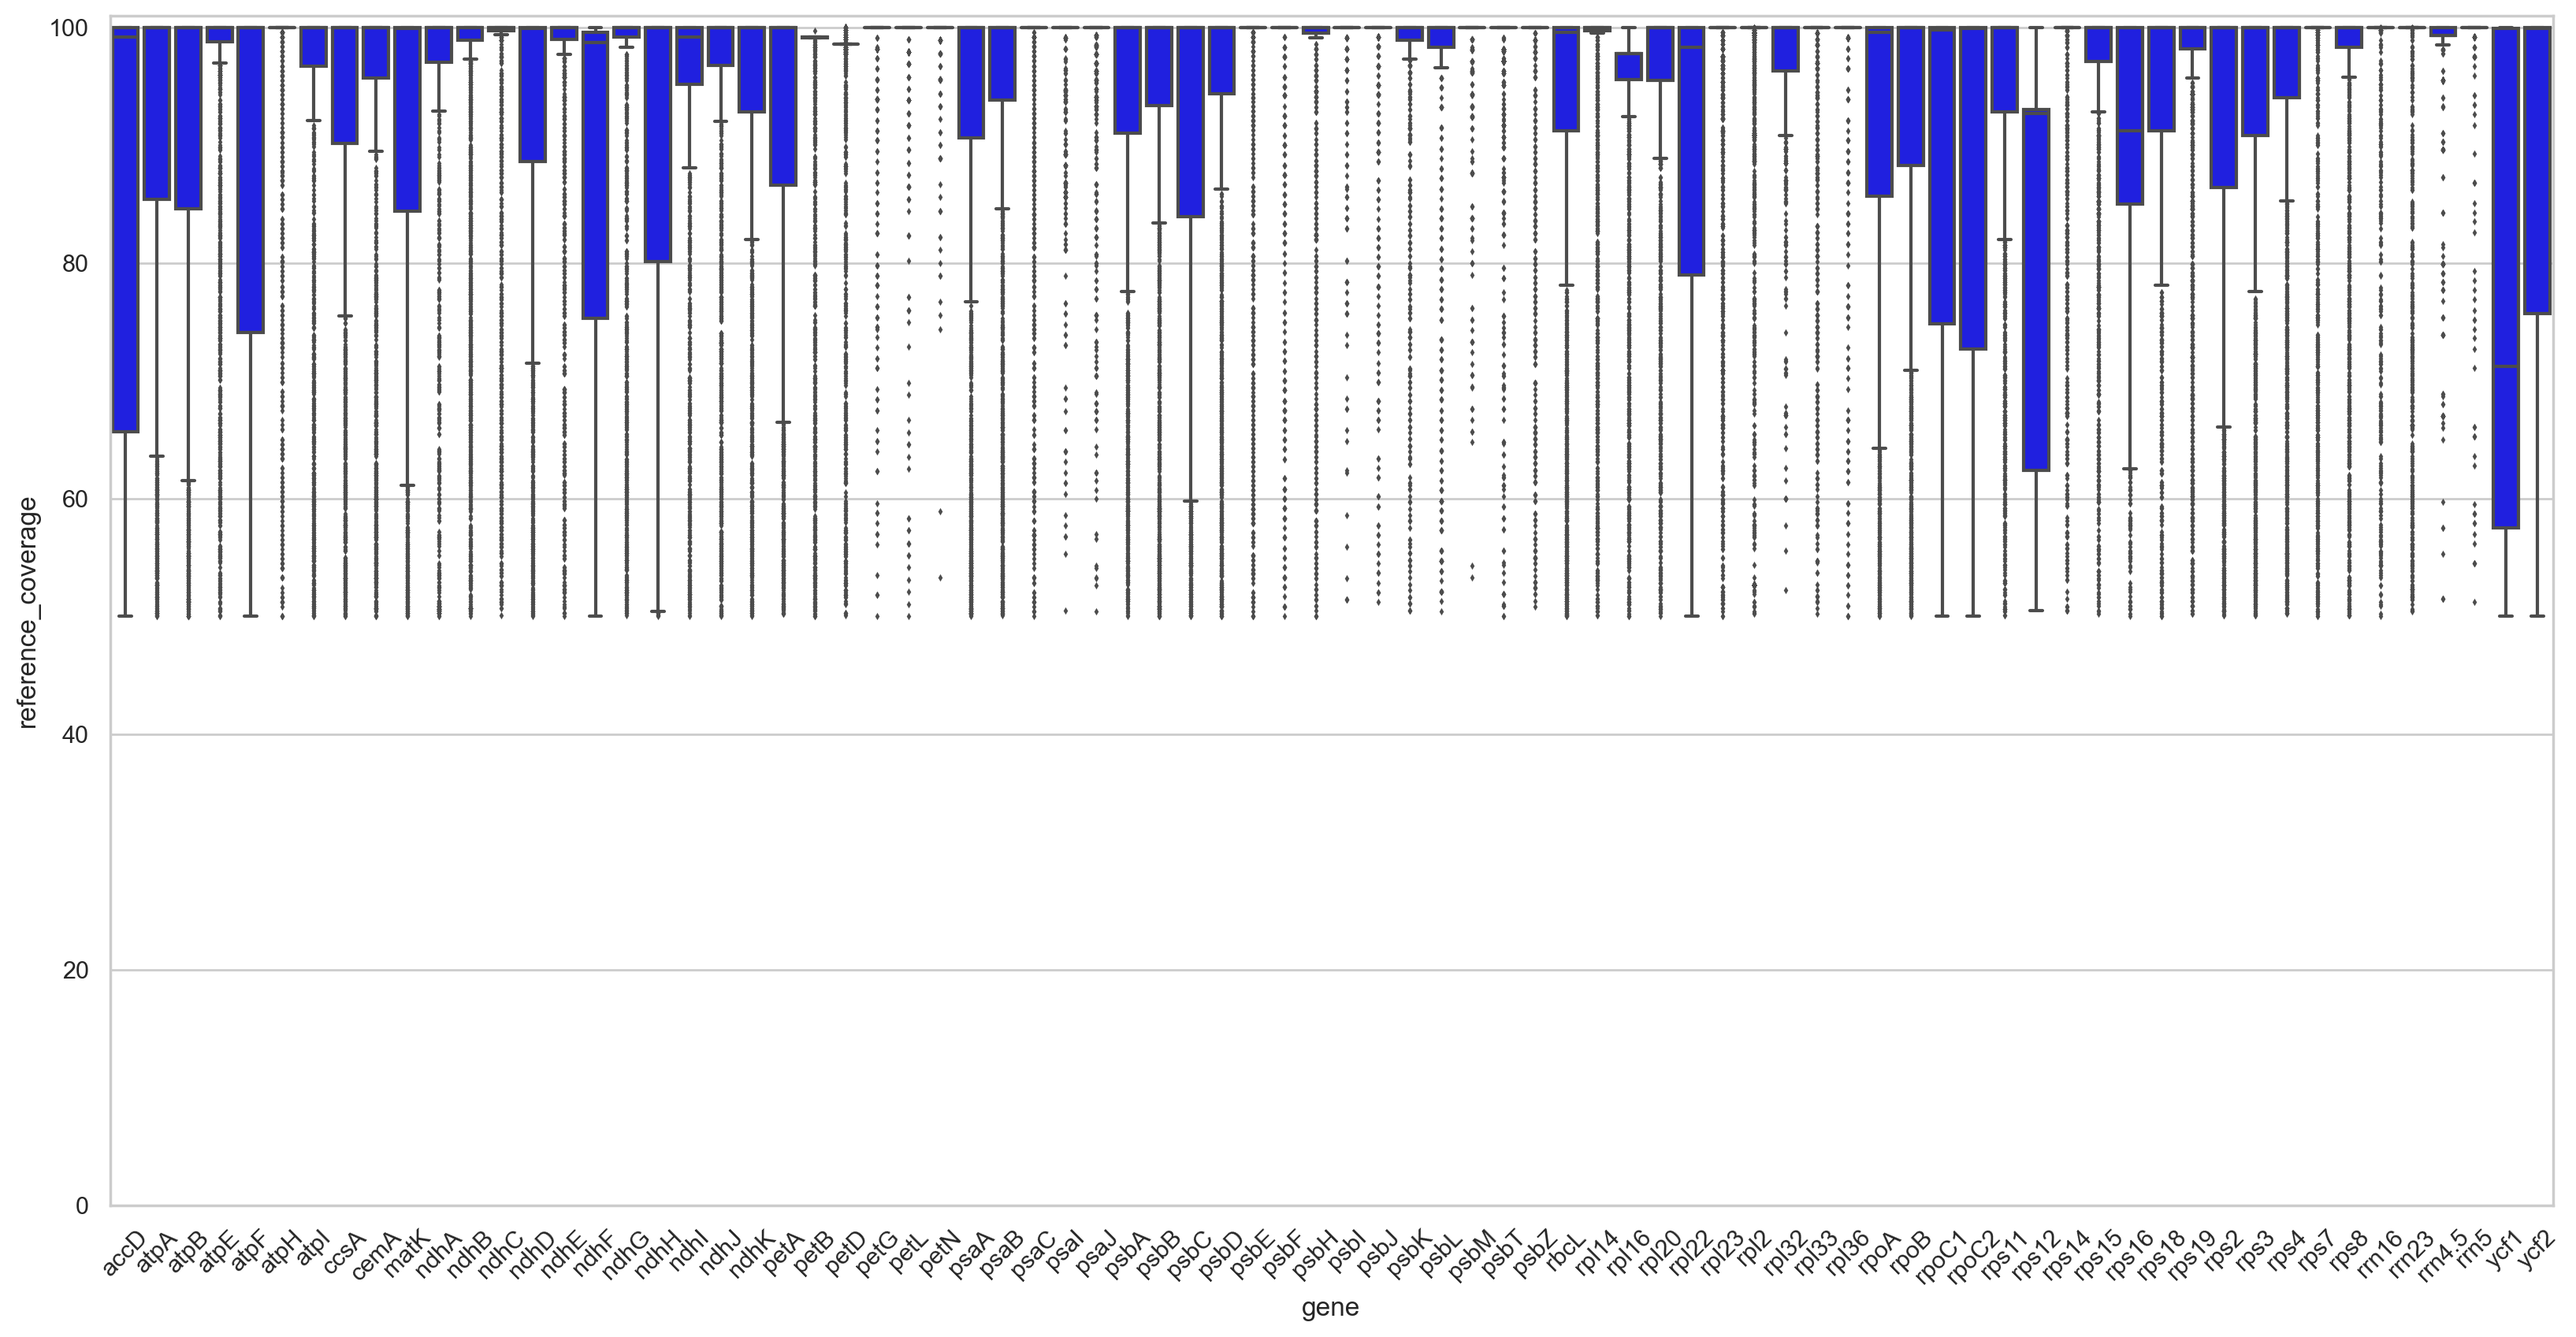

In [16]:
plt.figure(figsize=(20, 10), dpi=200)
sns.set(font_scale=1); sns.set_style("whitegrid")
flierprops = dict(markerfacecolor='1', markersize=1, linestyle='none')
sns.boxplot(x="gene", y="reference_coverage", data=all_stats_paftol, color='blue', flierprops=flierprops);
plt.xticks(rotation=45); plt.ylim(0,101);

## Pairwise distance

In [8]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment

In [160]:
aln = AlignIO.read(open('Aligned_genes/rrn5_aln.fasta'), 'fasta')
aln

<<class 'Bio.Align.MultipleSeqAlignment'> instance (15538 records of length 172) at 2eb60be8e80>

In [154]:
calculator = DistanceCalculator('identity',skip_letters='-')
dm = calculator.get_distance(aln[:10])
print(dm)

MT156366.1	0
OK585058.1	0.2931222707423581	0
ERR4210254	0.29858078602620086	0.2963973799126638	0
GAP_028661	0.33460698689956336	0.34170305676855894	0.34006550218340614	0
ZSD344	0.2963973799126638	0.28875545851528384	0.2893013100436681	0.3356986899563319	0
PAFTOL_005280	0.3051310043668122	0.29694323144104806	0.3084061135371179	0.334061135371179	0.29530567685589515	0
NC_051873.1	0.30240174672489084	0.29366812227074235	0.30076419213973804	0.32423580786026196	0.29748908296943233	0.28820960698689957	0
SRR125625	0.28711790393013104	0.2893013100436681	0.2942139737991266	0.3411572052401747	0.2958515283842795	0.3018558951965066	0.3029475982532751	0
FYTP	0.2854803493449781	0.2685589519650655	0.2822052401746725	0.334061135371179	0.2669213973799127	0.27838427947598254	0.28165938864628826	0.277292576419214	0
OK138594.1	0.3078602620087336	0.2931222707423581	0.30567685589519655	0.31604803493449785	0.2996724890829694	0.2876637554585153	0.27128820960698685	0.30240174672489084	0.2843886462882096	0
	MT15

In [ ]:
for order in orders:
    SamplesV_ord = SamplesV[SamplesV.order==order]
    print(order,SamplesV_ord.shape[0],SamplesV_ord.genus.nunique(),end='=')
    # Select 1 sample per genus
    SamplesV_ord_sel = SamplesV_ord.sort_values('length',ascending=False).groupby('genus').head(1)
    SamplesV_ord_sel_ls = SamplesV_ord_sel.Sample_Name.to_list()
    print(len(SamplesV_ord_sel_ls),end='>')
    aln_ls = []
    for ialn in aln:
        if ialn.name in SamplesV_ord_sel_ls:
            aln_ls.append(ialn)
    aln_order = MultipleSeqAlignment(aln_ls)
    print(len(aln_order),end=':')
    dm = calculator.get_distance(aln_order)
    print([float(sum(col))/len(col) for col in zip(*dm.matrix)])

In [ ]:
### Output alignment file per order

In [249]:
aln = AlignIO.read(open('Aligned_genes/' + 'petN' + '_aln.fasta'), 'fasta')
aln

<<class 'Bio.Align.MultipleSeqAlignment'> instance (14095 records of length 110) at 2eb2aa87cd0>

In [250]:
#https://stackoverflow.com/questions/28220301/python-remove-special-column-from-multiple-sequence-alignment
def cut_a_gap(align):
    n = float(len(align[0]))
    i = 0
    while i < n:
        if align[:, i].count('-')==len(align[:, i]):
            if i == 0:
                align = align[:, 1:]
            elif i+1 == n:
                align = align[:, :i]
            else:
                align = align[:, :i] + align[:, i+1:]
            n -= 1  #  seq. 1 shorter
        else:  #  nothing to delete, proceed
            i += 1
    return align

In [251]:
aln2 = cut_a_gap(align=aln)
aln2

<<class 'Bio.Align.MultipleSeqAlignment'> instance (14095 records of length 110) at 2eb2aa87cd0>

https://mothur.org/wiki/pairwise.seqs/

https://caramagnabosco.wordpress.com/2014/10/22/mothur/

In [ ]:
text_file = open('commands_mothur.txt', "w")
ls_gene_order_stats=[]
for gene in genes.gene:
    aln = AlignIO.read(open('Aligned_genes/' + gene + '_aln.fasta'), 'fasta')
    aln_names = [ialn.name for ialn in aln]
    print(gene,':',len(aln_names))
    for order in orders:
        SamplesV_ord = SamplesV[(SamplesV.order==order) & (SamplesV.Sample_Name.isin(aln_names))]
        print(' ', order,SamplesV_ord.shape[0],SamplesV_ord.genus.nunique(),end='=')
        # Select 1 sample per genus
        SamplesV_ord_sel = SamplesV_ord.sample(frac=1).groupby('genus').head(1)
        SamplesV_ord_sel_ls = SamplesV_ord_sel.Sample_Name.to_list()
        print(len(SamplesV_ord_sel_ls),end='=')
        aln_ls = []
        for ialn in aln:
            if ialn.name in SamplesV_ord_sel_ls:
                aln_ls.append(ialn)
        aln_order = MultipleSeqAlignment(aln_ls)
        print(len(aln_order),', ',len(aln_order[0]),end='>')
        aln_order_cut = cut_a_gap(aln_order)
        print(len(aln_order_cut[0]))
        SeqIO.write(aln_order, 'Aligned_genes_order/' + gene + '-' + order + '_aln.fasta', "fasta")
        ls_gene_order_stats.append({'gene':gene,'order':order,
                                    'Ngenus':SamplesV[(SamplesV.order==order)].genus.nunique(),'Nseq_genus':len(aln_order)})
        command = 'pairwise.seqs(fasta=../cpTree_v6/' + 'Aligned_genes_order/' + gene + '-' + order + '_aln.fasta' +\
              ', calc=onegap, output=square, countends=F, processors=8)\n'
#         print(command)


        #write string to file
        text_file.write(command)
#close file
text_file.close()

In [12]:
# Select one sample per genus per gene randomly
text_file = open('commands_mothur.txt', "w")
ls_gene_order_stats=[]
for gene in genes.gene:
    aln = AlignIO.read(open('Aligned_genes/' + gene + '_aln.fasta'), 'fasta')
    aln_names = [ialn.name for ialn in aln]
    print(gene,':',len(aln_names),end='>')
    # Select 1 sample per genus
#     SamplesV_sel = SamplesV[(SamplesV.Sample_Name.isin(aln_names))].sample(frac=1).groupby('genus').head(1)
    SamplesV_sel = SamplesV[(SamplesV.Sample_Name.isin(aln_names))].sort_values('length',ascending=False).groupby('genus').head(1)
    SamplesV_sel_ls = SamplesV_sel.Sample_Name.to_list()
    print(SamplesV_sel.genus.nunique(),'=',len(SamplesV_sel_ls),end='=')
    aln_ls = []
    for ialn in aln:
        if ialn.name in SamplesV_sel_ls:
            aln_ls.append(ialn)
    aln_sel = MultipleSeqAlignment(aln_ls)
    print(len(aln_sel))
    SeqIO.write(aln_sel, 'Aligned_genes_genus/' + gene + '_aln.fasta', "fasta")
    ls_gene_order_stats.append({'gene':gene,'Ngenus':SamplesV.genus.nunique(),'Nseq_genus':len(aln_sel)})
    command = 'pairwise.seqs(fasta=../cpTree_v6/' + 'Aligned_genes_genus/' + gene + '_aln.fasta' +\
          ', calc=onegap, output=square, countends=F, processors=8)\n'
#         print(command)


    #write string to file
    text_file.write(command)
#close file
text_file.close()

accD : 11135>4001 = 4001=4001
atpA : 14674>5132 = 5132=5132
atpB : 15071>5348 = 5348=5348
atpE : 15298>5472 = 5472=5472
atpF : 14865>5237 = 5237=5237
atpH : 15368>5561 = 5561=5561
atpI : 14544>5073 = 5073=5073
ccsA : 14036>4880 = 4880=4880
cemA : 14422>5065 = 5065=5065
clpP : 588>464 = 464=464
matK : 13992>4868 = 4868=4868
ndhA : 13673>4745 = 4745=4745
ndhB : 15447>5646 = 5646=5646
ndhC : 14236>5067 = 5067=5067
ndhD : 13706>4759 = 4759=4759
ndhE : 13718>4785 = 4785=4785
ndhF : 13222>4560 = 4560=4560
ndhG : 13825>4823 = 4823=4823
ndhH : 14367>5156 = 5156=5156
ndhI : 13680>4780 = 4780=4780
ndhJ : 14395>5075 = 5075=5075
ndhK : 14044>4977 = 4977=4977
petA : 15485>5626 = 5626=5626
petB : 14635>5122 = 5122=5122
petD : 14350>4960 = 4960=4960
petG : 13898>5000 = 5000=5000
petL : 13407>4777 = 4777=4777
petN : 14095>5157 = 5157=5157
psaA : 14545>5127 = 5127=5127
psaB : 14457>5055 = 5055=5055
psaC : 14396>4994 = 4994=4994
psaI : 13258>4754 = 4754=4754
psaJ : 14449>5306 = 5306=5306
psbA : 14843>52

In [219]:
dist_df = pd.read_table('Aligned_genes_order/' + gene + '-' + 'Asterales' + '_aln.square.dist',sep='\t',header=None, skiprows=1).set_index(0)
dist_df.columns = dist_df.index
dist_df

,PAFTOL_014851,SRR9118977,NC_039381.1,NC_057464.1,PAFTOL_016957,SRR9119059,PAFTOL_011361,MH183145.1,MK086040.2,NC_042610.1,...,MT074353.1,NC_057993.1,NC_028006.1,PAFTOL_005720,PAFTOL_014995,SRR9119051,PAFTOL_015125,SRR9119005,PAFTOL_005817,NC_034851.1
0,,,,,,,,,,,,,,,,,,,,,
PAFTOL_014851,0.000000,0.030640,0.02232,0.026500,0.06897,0.03068,0.04318,0.01255,0.023710,0.02371,...,0.07103,0.03068,0.034870,0.03487,0.03905,0.03626,0.03487,0.02507,0.006974,0.04324
SRR9118977,0.030640,0.000000,0.01405,0.009838,0.02270,0.01616,0.02384,0.02530,0.012650,0.02530,...,0.05952,0.02178,0.007027,0.02125,0.02926,0.02809,0.01897,0.02661,0.030970,0.02530
NC_039381.1,0.022320,0.014050,0.00000,0.014770,0.02937,0.01547,0.02600,0.02672,0.005626,0.02743,...,0.06114,0.01195,0.017580,0.02576,0.03033,0.03092,0.02461,0.03092,0.024550,0.03024
NC_057464.1,0.026500,0.009838,0.01477,0.000000,0.02270,0.01336,0.02460,0.02391,0.012660,0.02813,...,0.05903,0.02391,0.012660,0.02016,0.03138,0.03092,0.01899,0.02952,0.025840,0.02743
PAFTOL_016957,0.068970,0.022700,0.02937,0.022700,0.00000,0.03071,0.02804,0.04139,0.030710,0.04272,...,0.07210,0.03471,0.021360,0.03422,0.03374,0.03733,0.03471,0.03605,0.062500,0.03204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9119051,0.036260,0.028090,0.03092,0.030920,0.03733,0.03233,0.04003,0.03443,0.028810,0.03443,...,0.07093,0.03514,0.032330,0.02576,0.02929,0.00000,0.03373,0.03301,0.037470,0.02881
PAFTOL_015125,0.034870,0.018970,0.02461,0.018990,0.03471,0.02391,0.02952,0.02813,0.021100,0.03235,...,0.06395,0.03305,0.021800,0.02576,0.03243,0.03373,0.00000,0.03514,0.032300,0.02813
SRR9119005,0.025070,0.026610,0.03092,0.029520,0.03605,0.03162,0.03156,0.02108,0.029520,0.02460,...,0.07563,0.03373,0.030220,0.03356,0.03866,0.03301,0.03514,0.00000,0.028390,0.03373


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

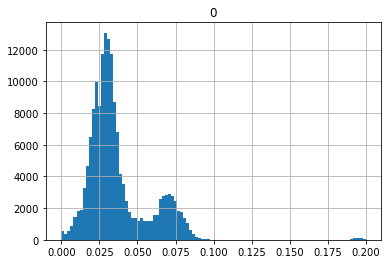

In [215]:
dist_df.stack()[dist_df.stack()<0.2].to_frame().hist(bins=100)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

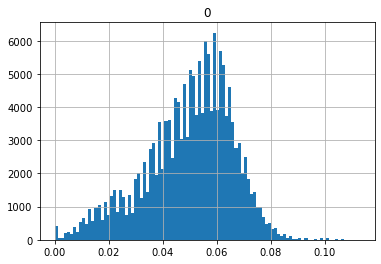

In [207]:
dist_df.stack().to_frame().hist(bins=100)

## Trimmed alignment stats

In [65]:
min_sample = 1

In [66]:
# List alignment files
aln_files = [file for file in os.listdir('Aligned_genes_trimmed') if file.endswith('fasta')]
print(len(aln_files),'alignment files')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Aligned_genes_trimmed'

In [ ]:
# read sequences

for aln_file in aln_files:
    aln_dc = SeqIO.to_dict(SeqIO.parse('Aligned_genes_trimmed/' + aln_file, format='fasta'))
    aln_s = Samples[Samples.Sample.isin(aln_dc.keys())]
    print(aln_file,':',len(aln_dc),'sequences, found',aln_s.shape[0],'in label file')

    # Get stats by given taxonomic level
    try:
        os.mkdir('tmp_AMAS')
    except:
        pass

    for taxa in aln_s[tax_level].unique():
        aln_s_tax = aln_s[aln_s[tax_level]==taxa]
        if aln_s_tax.shape[0] >= min_sample:
            aln_tax =  [aln_dc[sample] for sample in aln_s_tax.Sample]
            print(len(aln_tax),'samples for',taxa)
            SeqIO.write(aln_tax,'tmp_AMAS/' + aln_file.replace('.fasta','-' + taxa + '.fasta'),format='fasta')
            # AMAS.py summary -f fasta -d dna -i tmp_AMAS/*.fasta -c 4
        else:
            print('insufficient samples',taxa)

In [ ]:
# AMAS.py summary -f fasta -d dna -i tmp_AMAS/*.fasta -c 4
# AMAS.py summary -f fasta -d dna -i Aligned_genes_order/*.fasta -c 4
# AMAS.py summary -f fasta -d dna -i Aligned_genes_order/rbcL-Fabales_aln.fasta -c 1
# AMAS.py summary -f fasta -d dna -i Aligned_genes_genus/*_aln_trimmed.fasta -c 4

### Parsimony informative

In [ ]:
min_sample = 10
stats = pd.read_table('summary.txt')
stats[['gene','order']]=stats.Alignment_name.str.replace('_alnT','').str.replace('.fasta','').str.split('-',expand=True)
# remove root orders
root_orders = ['Pinales','Gnetales','Cupressales','Ginkgoales','Ephedrales','Cupressales','Araucariales','Cycadales','Taxales']
stats = stats[stats.order.isin(root_orders)==False]
stats[:2]

In [ ]:
stats.to_csv('stats.csv',index=False)

In [ ]:
# Load order of genes and taxonomic level
with open('../gene_list_sorted_Arabidopsis.txt') as f:
    genes = [line.rstrip() for line in f]
print(len(genes),genes[:2])

In [ ]:
tax_order = pd.read_csv('../order_order.csv')
print(tax_order.shape[0])
tax_order = tax_order[tax_order.order.isin(stats.order)].groupby('order').head(1)
print(tax_order.shape[0])
tax_order[:2]

In [ ]:
stats_m= stats[stats['No_of_taxa']>=min_sample][['order','gene','Proportion_parsimony_informative']]\
                .set_index(['order','gene']).unstack().droplevel(0, axis=1)
# order genes 
stats_m = stats_m[[gene for gene in genes if gene in list(stats_m.columns)]]
stats_m = stats_m.reindex(list(tax_order.order)).drop_duplicates(keep='first')
print(stats_m.shape[0])
stats_m[:2]

In [ ]:
figure(figsize=(round(stats_m.shape[1]/3,1), round(stats_m.shape[0]/3,1)), dpi=200)
sns.heatmap(stats_m,cmap=sns.color_palette("viridis", as_cmap=True));

In [ ]:
figure(figsize=(15, 10), dpi=200)
ax = sns.boxplot(x="gene", y="Proportion_parsimony_informative", data=stats[stats['No_of_taxa']>=min_sample]);
ax.set_xticklabels(ax.get_xticklabels(),rotation=75);

In [ ]:
figure(figsize=(8, 6), dpi=100)
avg_gene = stats[stats['No_of_taxa']>=min_sample].groupby('gene').agg({
    'Alignment_length':['mean'],'Proportion_parsimony_informative':['mean']}).droplevel(1, axis=1)
sns.scatterplot(x='Alignment_length',y='Proportion_parsimony_informative',
                data = avg_gene);
avg_gene['r'] = avg_gene.Proportion_parsimony_informative/avg_gene.Alignment_length
avg_gene.sort_values('r',ascending=False)[:5]

In [ ]:
figure(figsize=(8, 6), dpi=100)
avg_tax = stats[stats['No_of_taxa']>=min_sample].groupby('order').agg({
    'No_of_taxa':['mean'],'Proportion_variable_sites':['mean']}).droplevel(1, axis=1)
sns.scatterplot(x='No_of_taxa',y='Proportion_variable_sites',
                data = avg_tax);
avg_tax['r'] = avg_tax.Proportion_variable_sites/avg_tax.No_of_taxa
avg_tax.sort_values('r',ascending=False)[:5]

In [ ]:
sns.scatterplot(x='Proportion_parsimony_informative',y='Proportion_variable_sites',data=stats)

In [ ]:
# best r by order
best_gene = stats[stats['No_of_taxa']>=min_sample]
best_gene['r'] = best_gene.Proportion_parsimony_informative/best_gene.Alignment_length
best_r = best_gene.sort_values('r',ascending=False).groupby('order').head(1)
print('by ratio:',best_r.groupby('gene').size().sort_values(ascending=False).to_dict())
best_pi = best_gene.sort_values('Proportion_parsimony_informative',ascending=False).groupby('order').head(1)
print('by Proportion_parsimony_informative:',best_pi.groupby('gene').size().sort_values(ascending=False).to_dict())

### Parsimony informative 2

In [31]:
sorted_genes = pd.read_table('../gene_list_sorted_Arabidopsis.txt',header=None).rename(columns={0:'gene'})
print(sorted_genes.shape[0],sorted_genes.columns)
genes = pd.read_csv('../cp_genes_82.txt',header=None).rename(columns={0:'gene'})
print(genes.shape)
sorted_genes = sorted_genes[sorted_genes.gene.isin(genes.gene)].groupby('gene').head(1).reset_index().rename(columns={'index':'gene_order'})
print(sorted_genes.shape)
sorted_genes.head(2)

124 Index(['gene'], dtype='object')
(82, 1)
(82, 2)


,gene_order,gene
0,0,rps12
1,2,psbA


In [32]:
ls_amas = [ifile for ifile in os.listdir('Pairwise_Distances/') if 'summary.txt' in ifile]
amas_df = pd.DataFrame()
for iamas in ls_amas:
    amas_df = pd.concat([amas_df, pd.read_table('Pairwise_Distances/' + iamas)],ignore_index=True)
amas_df['gene'] = amas_df['Alignment_name'].str.replace('_aln_trimmed.fasta','')
print(amas_df.shape)
amas_df = pd.merge(amas_df[amas_df.No_of_taxa>2000],sorted_genes,how='left',on='gene')
print(amas_df.shape)
amas_df.head(2)

(82, 32)
(78, 33)


,Alignment_name,No_of_taxa,Alignment_length,Total_matrix_cells,Undetermined_characters,Missing_percent,No_variable_sites,Proportion_variable_sites,Parsimony_informative_sites,Proportion_parsimony_informative,...,V,H,D,X,N,O,-,?,gene,gene_order
0,accD_aln_trimmed.fasta,4001,9390,37569390,32157671,85.595,3756,0.400,2372,0.253,...,0,0,0,0,124,0,32157547,0,accD,49
1,atpA_aln_trimmed.fasta,5132,1686,8652552,1042881,12.053,1301,0.772,1110,0.658,...,0,0,0,0,25,0,1042856,0,atpA,12


<AxesSubplot:xlabel='No_of_taxa', ylabel='Proportion_parsimony_informative'>

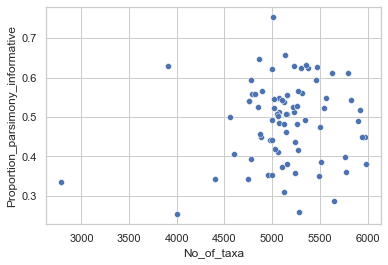

In [33]:
sns.scatterplot(x='No_of_taxa', y='Proportion_parsimony_informative', data=amas_df)

[{'gene': 'rpl36', 'Proportion_parsimony_informative': 0.754}, {'gene': 'atpA', 'Proportion_parsimony_informative': 0.6579999999999999}, {'gene': 'psbM', 'Proportion_parsimony_informative': 0.647}, {'gene': 'psbZ', 'Proportion_parsimony_informative': 0.632}, {'gene': 'rpl14', 'Proportion_parsimony_informative': 0.63}, {'gene': 'rpl32', 'Proportion_parsimony_informative': 0.63}, {'gene': 'atpE', 'Proportion_parsimony_informative': 0.626}, {'gene': 'psbJ', 'Proportion_parsimony_informative': 0.625}, {'gene': 'psaJ', 'Proportion_parsimony_informative': 0.624}, {'gene': 'petG', 'Proportion_parsimony_informative': 0.622}]


<AxesSubplot:xlabel='Missing_percent', ylabel='Proportion_parsimony_informative'>

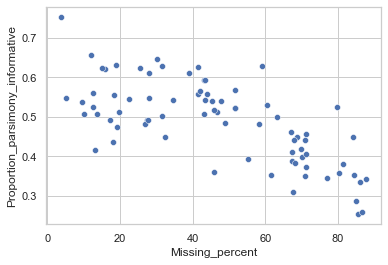

In [34]:
print(amas_df.sort_values('Proportion_parsimony_informative',ascending=False)[['gene','Proportion_parsimony_informative']][:10].to_dict('records'))
sns.scatterplot(x='Missing_percent', y='Proportion_parsimony_informative', data=amas_df)

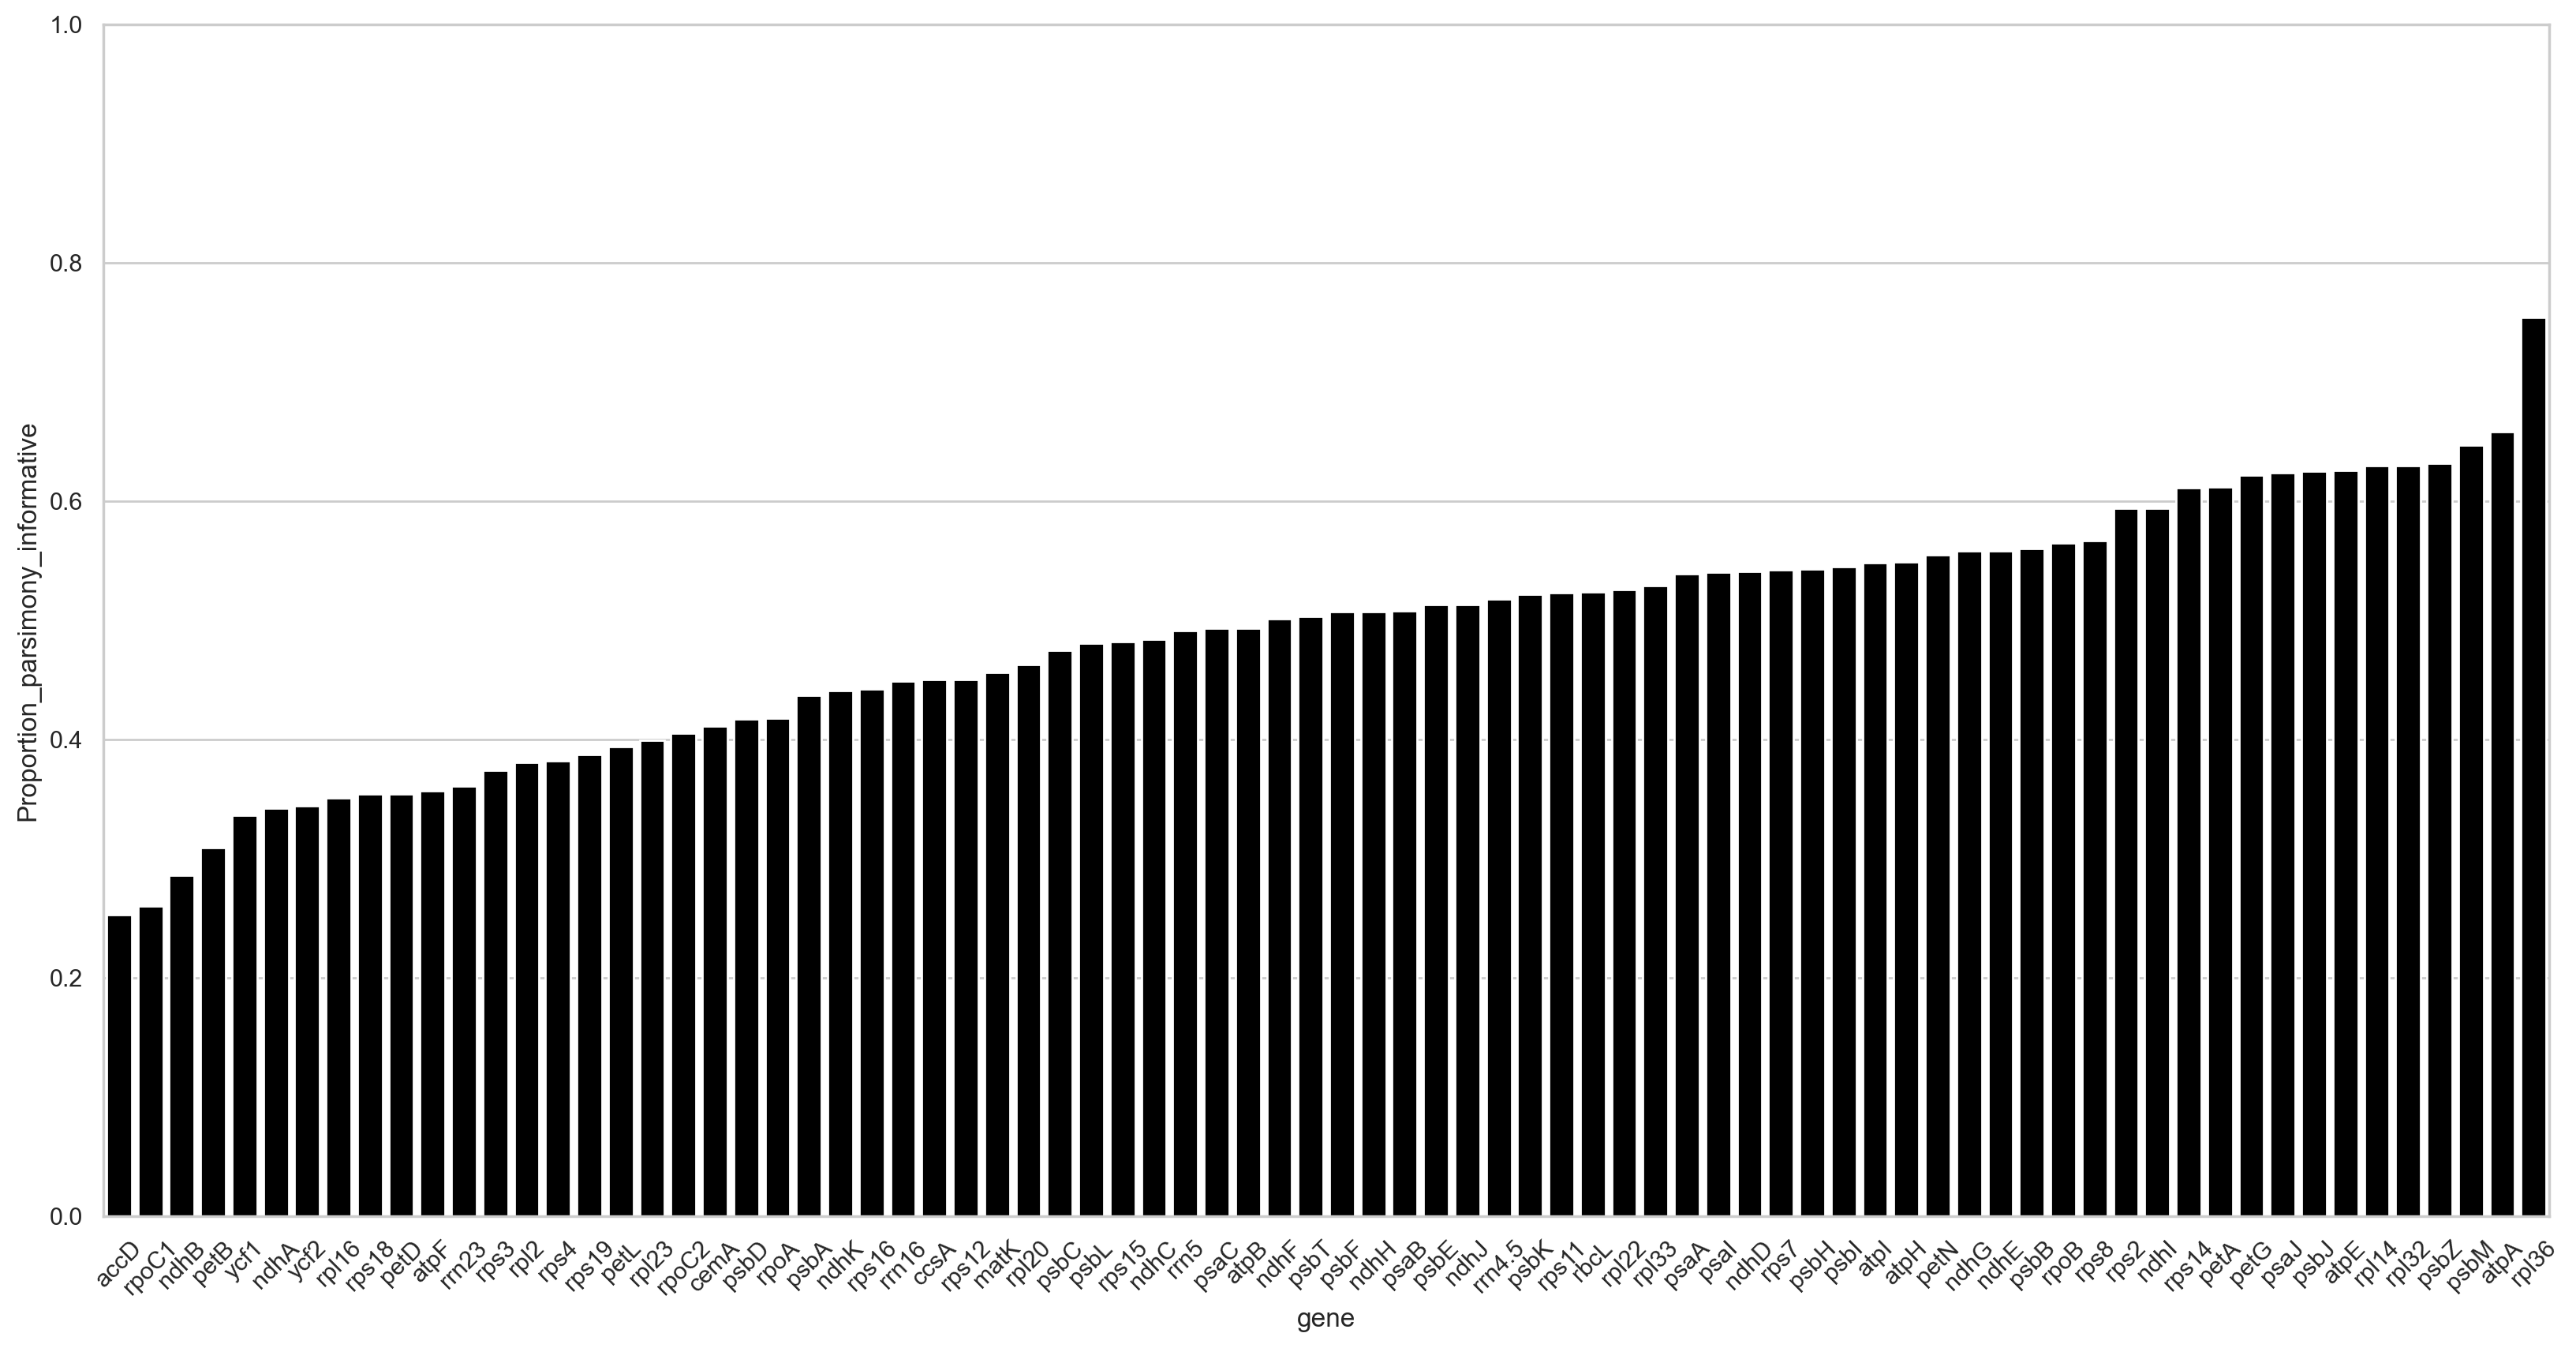

In [17]:
plt.figure(figsize=(20, 10), dpi=200)
sns.set(font_scale=1); sns.set_style("whitegrid")
flierprops = dict(markerfacecolor='1', markersize=1, linestyle='none')
sns.barplot(x = 'gene', y = 'Proportion_parsimony_informative', data = amas_df.sort_values('Proportion_parsimony_informative'), color='black')
plt.xticks(rotation=45); plt.ylim(0,1);

<AxesSubplot:xlabel='No_of_taxa', ylabel='gene'>

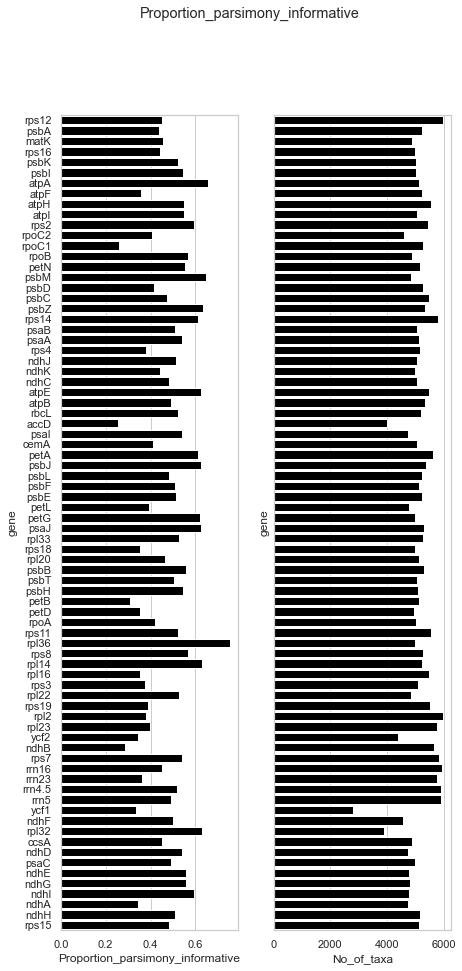

In [35]:
fig, axes = plt.subplots(1,2, figsize=(7, 15), sharey=True)
fig.suptitle('Proportion_parsimony_informative')

# Bulbasaur
sns.barplot(ax=axes[0], x = 'Proportion_parsimony_informative', y = 'gene',data = amas_df.sort_values('gene_order'), color='black')


# Charmander
sns.barplot(ax=axes[1],  x = 'No_of_taxa', y = 'gene',data = amas_df.sort_values('gene_order'), color='black')

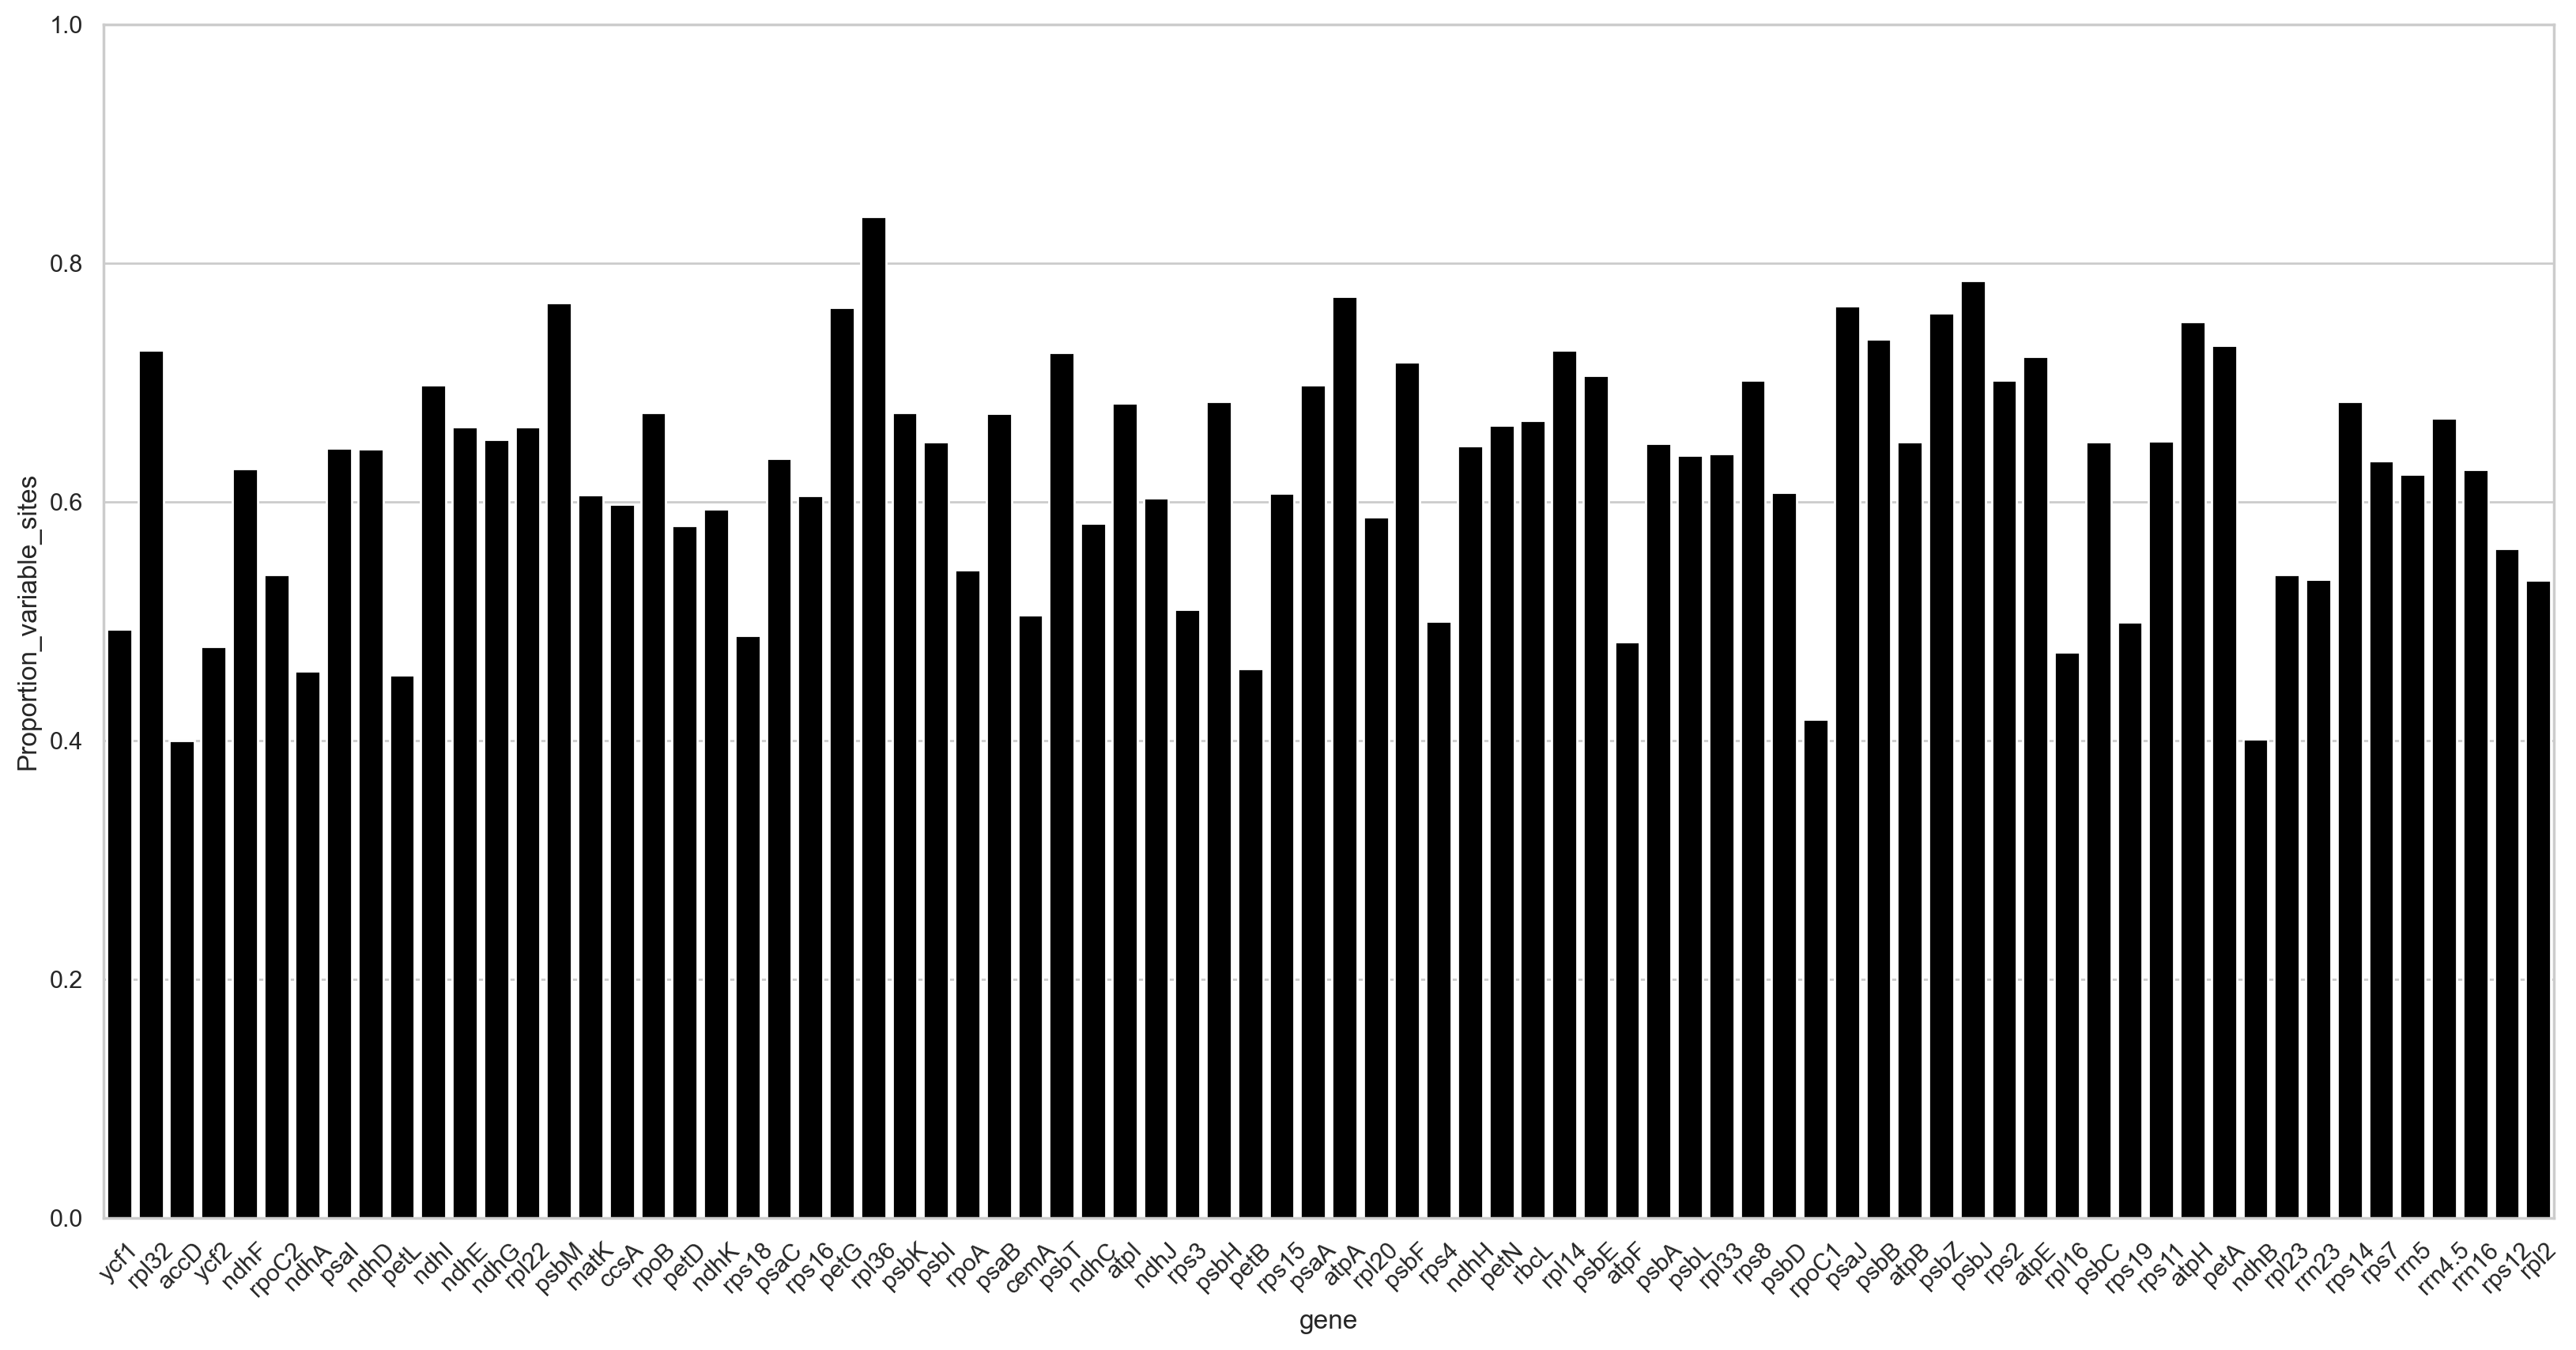

In [19]:
plt.figure(figsize=(20, 10), dpi=200)
sns.set(font_scale=1); sns.set_style("whitegrid")
flierprops = dict(markerfacecolor='1', markersize=1, linestyle='none')
sns.barplot(x = 'gene', y = 'Proportion_variable_sites', data = amas_df.sort_values('No_of_taxa'), color='black')
plt.xticks(rotation=45); plt.ylim(0,1);

# Save

In [24]:
import os
os.system('jupyter nbconvert --to html --output ' +
          wdir + wdir.replace('/','_') + 'Tree_Analysis ../cpAlignment_Analysis.ipynb')

0